Universidad del Valle de Guatemala
Security Data Science

# Análisis de Malware
## Hoja de Trabajo #1

Walter Saldaña #19897
___

In [77]:
import pandas as pd
import hashlib

In [3]:
%pip install pefile
import pefile

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 KB 839.7 kB/s eta 0:00:00m eta 0:00:01:01
You should consider upgrading via the '/usr/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [59]:
def get_pe_apis(pe):
    apis = []
    for entry in pe.DIRECTORY_ENTRY_IMPORT:
        dll_name = entry.dll.decode('utf-8')
        print(f"{dll_name}: ")
        for func in entry.imports:
            print("\t- %s at 0x%08x" % (func.name.decode('utf-8'), func.address))
            apis.append(func.name.decode('utf-8'))
    return apis

In [53]:
def get_pe_sections(pe):
    for section in pe.sections:
        print(
            section.Name.decode('utf-8'),
            hex(section.VirtualAddress),
            hex(section.Misc_VirtualSize),
            section.SizeOfRawData
        )

# Parte 1 - Análisis estático

### 1. Utilice la herramienta pefile para examinar el PE header y obtenga las DLL y las APIs que cada  uno  de  los  ejecutables  utilizan.  ¿Qué  diferencias  observa  entre  los  ejemplos?  ¿Existe  algún  indicio sospechoso en la cantidad de DLLs y las APIs llamadas? 

**sample_qwrty_dk2**

In [23]:
pe = pefile.PE('MALWR/sample_qwrty_dk2')

In [61]:
apis = get_pe_apis(pe)

KERNEL32.DLL: 
	- LoadLibraryA at 0x004070d0
	- ExitProcess at 0x004070d4
	- GetProcAddress at 0x004070d8
	- VirtualProtect at 0x004070dc
MSVCRT.dll: 
	- atol at 0x004070e4
SHELL32.dll: 
	- SHChangeNotify at 0x004070ec
USER32.dll: 
	- LoadStringA at 0x004070f4
WS2_32.dll: 
	- closesocket at 0x004070fc


**sample_vg655_25th.exe**

In [26]:
pe2 = pefile.PE('MALWR/sample_vg655_25th.exe')

In [60]:
apis2 = get_pe_apis(pe2)

KERNEL32.dll: 
	- GetFileAttributesW at 0x0040802c
	- GetFileSizeEx at 0x00408030
	- CreateFileA at 0x00408034
	- InitializeCriticalSection at 0x00408038
	- DeleteCriticalSection at 0x0040803c
	- ReadFile at 0x00408040
	- GetFileSize at 0x00408044
	- WriteFile at 0x00408048
	- LeaveCriticalSection at 0x0040804c
	- EnterCriticalSection at 0x00408050
	- SetFileAttributesW at 0x00408054
	- SetCurrentDirectoryW at 0x00408058
	- CreateDirectoryW at 0x0040805c
	- GetTempPathW at 0x00408060
	- GetWindowsDirectoryW at 0x00408064
	- GetFileAttributesA at 0x00408068
	- SizeofResource at 0x0040806c
	- LockResource at 0x00408070
	- LoadResource at 0x00408074
	- MultiByteToWideChar at 0x00408078
	- Sleep at 0x0040807c
	- OpenMutexA at 0x00408080
	- GetFullPathNameA at 0x00408084
	- CopyFileA at 0x00408088
	- GetModuleFileNameA at 0x0040808c
	- VirtualAlloc at 0x00408090
	- VirtualFree at 0x00408094
	- FreeLibrary at 0x00408098
	- HeapAlloc at 0x0040809c
	- GetProcessHeap at 0x004080a0
	- GetModuleH

Las principales diferencias que se observan entre los ejemplos es que el primer ejecutable casi no realiza llamadas a sistema, mientras que el segundo realiza demasiadas y en diferentes DLLs como por ejemplo ADAPI32.

Sobre el punto anterior, si existen sospechas sobre el segundo ejecutable, ya que demasiadas llamadas a sistema implican demasiada manipulación del sistema operativo para acceder a funciones del kernel.

### 2. Obtenga la información de las secciones del PE Header. ¿Qué significa que algunas secciones  tengan como parte de su nombre “upx”? Realice el procedimiento de desempaquetado para  obtener las llamadas completas de las APIs. 

In [54]:
get_pe_sections(pe)

UPX0     0x1000 0x5000 0
UPX1     0x6000 0x1000 4096
.rsrc    0x7000 0x1000 512


In [55]:
get_pe_sections(pe2)

.text    0x1000 0x69b0 28672
.rdata   0x8000 0x5f70 24576
.data    0xe000 0x1958 8192
.rsrc    0x10000 0x349fa0 3448832


Que tengan UPX en su nombre implica que se utilizó un packer para comprimir el ejecutable, aunque también se utilizan para complicar el acceso al codigo fuente en binario. 

### 3. Según el paper “Towards Understanding Malware Behaviour by the Extraction of API Calls”,  ¿en  que  categoría  sospechosas  pueden  clasificarse  estos  ejemplos  en  base  a  algunas  de  las  llamadas a las APIs que realizan? Muestre una tabla con las APIs sospechosas y la categoría de  malware que el paper propone. 

In [58]:
names = {
    1: 'Search Files to Infect',
    2: 'Copy/Delete Files',
    3: 'Get File Information',
    4: 'Move Files',
    5: 'Read/Write Files',
    6: 'Change File Attributes',
}

behaviours = {
    1: ['FindClose', 'FindFirstFile', 'FindFirstFileEx', 'FindFirstFileName', 'TransactedW',
         'FindFirstFileNameW', 'FindFirstFileTransacted', 'FindFirstStream', 'TransactedW',
         'FindFirstStreamW', 'FindNextFile', 'FindNextFileNameW', 'FindNextStreamW', 'SearchPath'],
    2: ['CloseHandle', 'CopyFile', 'CopyFileEx', 'CopyFileTransacted', 'CreateFile', 'CreateFileTransacted',
        'CreateHardLink', 'CreateHardLink', 'Transacted', 'CreateSymbolicLink', 'CreateSymbolic',
        'LinkTransacted', 'DeleteFile', 'DeleteFileTransacted'],
    3: ['GetBinaryType', 'GetCompressed', 'FileSize', 'GetCompressedFile', 'SizeTransacted',
        'GetFileAttributes', 'GetFileAttributesEx', 'GetFileAttributes', 'Transacted', 'GetFileBandwidth',
        'Reservation', 'GetFileInformation', 'ByHandle', 'GetFileInformation', 'ByHandleEx', 'GetFileSize',
        'GetFileSizeEx', 'GetFileType', 'GetFinalPathName', 'ByHandle', 'GetFullPathName', 'GetFullPathName',
        'Transacted', 'GetLongPathName', 'GetLongPathName', 'Transacted', 'GetShortPathName',
        'GetTempFileName', 'GetTempPath'],
    4: ['MoveFile', 'MoveFileEx', 'MoveFileTransacted', 'MoveFileWithProgress'],
    5: ['OpenFile', 'OpenFileById', 'ReOpenFile', 'ReplaceFile', 'WriteFile', 'CreateFile', 'CloseHandle'],
    6: ['SetFileApisToANSI', 'SetFileApisToOEM', 'SetFileAttributes', 'SetFileAttributesTransacted',
        'SetFileBandwidthReservation', 'SetFileInformationByHandle', 'SetFileShortName', 'SetFileValidData'],
}

In [74]:
def get_sus_apis(apis):
    sus_apis = {
        'API': [],
        'Category': [],
    }

    for api in apis:
        for i in range(1, len(behaviours.keys()) + 1):
            if api in behaviours[i]:
                sus_apis['API'].append(api)
                sus_apis['Category'].append(names[i])

    return pd.DataFrame.from_dict(sus_apis)               

**sample_qwrty_dk2**

In [76]:
get_sus_apis(apis)

,API,Category


|API|Categoría|
|---|---|
|LoadLibraryA|-|
|ExitProcess|-|
|GetProcAddress|-|
|VirtualProtect|-|
|atol|-|
|SHChangeNotify|-|
|LoadStringA|-|
|closesocket|-|

**sample_vg655_25th.exe**

In [75]:
get_sus_apis(apis2)

,API,Category
0,GetFileSizeEx,Get File Information
1,GetFileSize,Get File Information
2,WriteFile,Read/Write Files
3,CloseHandle,Copy/Delete Files
4,CloseHandle,Read/Write Files


### 4. Para el archivo “sample_vg655_25th.exe” obtenga el HASH en base al algoritmo SHA256. 

In [80]:
def sha256sum(filename):
    h  = hashlib.sha256()
    b  = bytearray(128*1024)
    mv = memoryview(b)
    with open(filename, 'rb', buffering=0) as f:
        while n := f.readinto(mv):
            h.update(mv[:n])
    return h.hexdigest()

In [82]:
my_sha = sha256sum('MALWR/sample_vg655_25th.exe')
my_sha

'ed01ebfbc9eb5bbea545af4d01bf5f1071661840480439c6e5babe8e080e41aa'

### 5. Para el archivo “sample_vg655_25th.exe”, ¿cuál es el propósito de la DLL ADVAPI32.dll? 

La DLL ADVAPI32 es la "Advanced API services library" que aporta APIS avanzadas incluyendo llamadas de registros y seguridad.

Particularmente, el ejecutable en cuestión utiliza las siguientes apis de dicha DLL, que según la documentación, realizan las siguientes funciones:
- **CreateServiceA:** Crea un objeto de servicio y lo agrega a la base de datos del administrador de control de servicios especificada.
- **OpenServiceA:** Abre un servicio existente
- **StartServiceA:** inicia un servicio
- **CloseServiceHandle:** Cierra un identificador de un administrador de control de servicios o un objeto de servicio.
- **CryptReleaseContext:** Libera el identificador de un proveedor de servicios criptográficos (CSP) y un contenedor de claves
- **RegCreateKeyW:** Crea la clave de registro especificada
- **RegSetValueExA:** Establece los datos y el tipo de un valor especificado bajo una clave de registro
- **RegQueryValueExA:** Recupera el tipo y los datos del nombre de valor especificado asociado con una clave de registro abierta
- **RegCloseKey:** Cierra un identificador de la clave de registro especificada
- **OpenSCManagerA:** Establece una conexión con el administrador de control de servicios en la computadora especificada y abre la base de datos del administrador de control de servicios especificado

Por lo que podemos notar que el propósito de utilizar ADAPI32 en el ejecutable es manejar servicios de encripción.

### 6. Para  el  archivo  “sample_vg655_25th.exe”,  ¿cuál  es  el  propósito  de  la  API CryptReleaseContext?

En el inciso anterior se indicaba de dicha API retorna un CSP, y más a detalle encontramos lo que eso significa

**(CSP):** Un módulo de software independiente que realmente ejecuta algoritmos criptográficos para autenticación, codificación y encriptación.

Así que podemos deducir que su propósito es encriptar información.

### 7. Con  la  información  recopilada  hasta  el  momento,  indique  para  el  archivo “sample_vg655_25th.exe” si es sospechoso o no, y cual podría ser su propósito. 

Para identificar si el ejecutable es sospechoso, primero hay que hacer notar que las apis que utiliza categorizadas como sospechosas según el paper son sobre los siguientes comportamientos:
- Obtener información de archivos
- Lectura y escritura de archivos
- Copiar y eliminar archivos

Luego, se puede observar que dentro de las DLL se utiliza ADAPI32 para ejecutar servicios de encripción, particularmente con la API CryptReleaseContext.

Entonces, uniendo estos dos hallazgos, podemos suponer que el ejecutable **si es sospechoso y que su propósito es el de un RANSOMWARE**, es decir, encriptar archivos de un sistema sin autorización del usuario y extorsionar para que el usuario pueda recuperarlos.

# Parte 2 - Análisis dinámico

### 8. Utilice la plataforma de análisis dinámico https://www.hybrid-analysis.com y cargue el archivo “sample_vg655_25th.exe”. ¿Se corresponde el HASH de la plataforma con el generado? ¿Cuál es el nombre del malware encontrado? ¿Cuál es el propósito de este malware? 

In [83]:
my_sha == 'ed01ebfbc9eb5bbea545af4d01bf5f1071661840480439c6e5babe8e080e41aa'

True

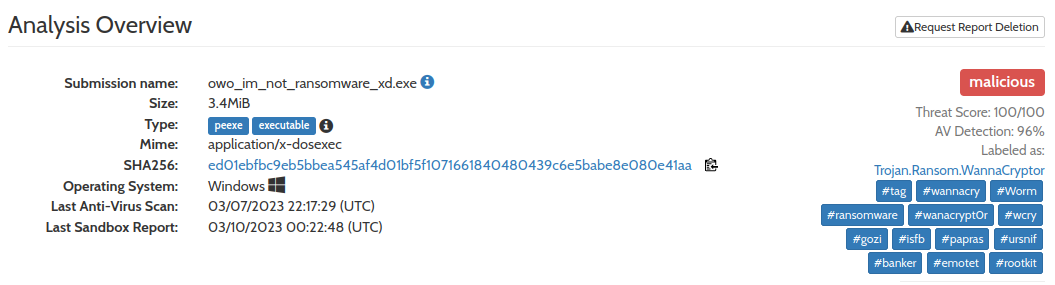

Si corresponde al Hash generado.

- **Nombre:** owo_im_not_ransomware_xd.exe
- **Propósito:** Ransomware, trojan, WannaCryptor

### 9. Muestre  las  capturas  de  pantalla  sobre  los  mensajes  que  este  malware  presenta  a  usuario. ¿Se corresponden las sospechas con el análisis realizado en el punto 7? 

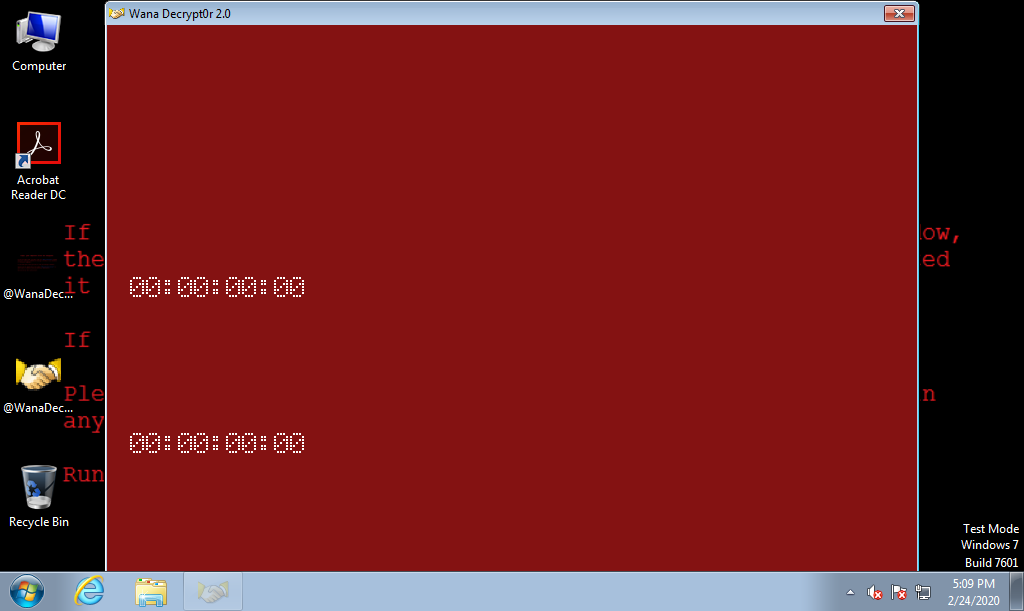

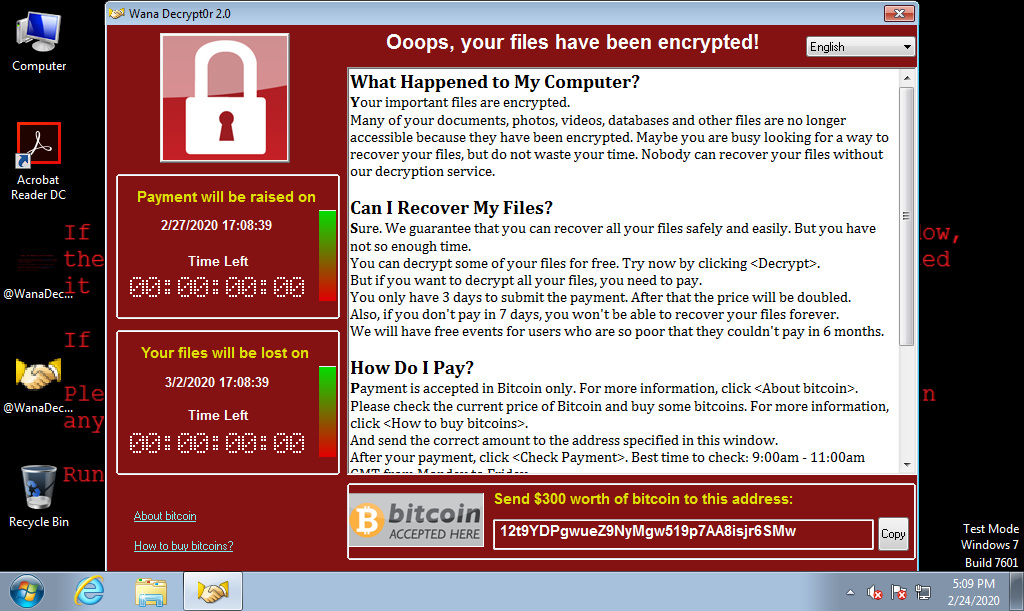

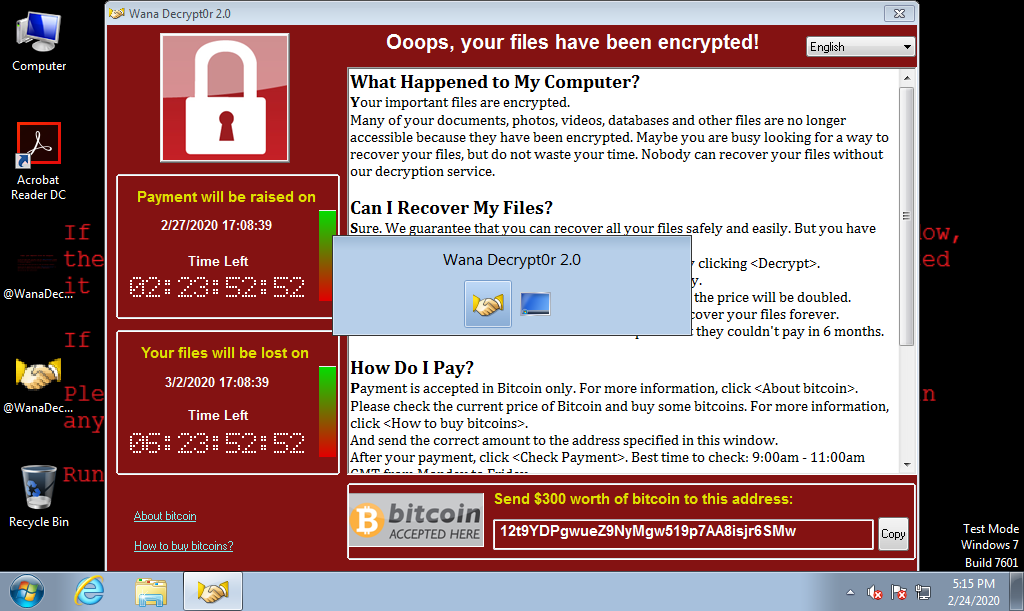

Las sospechas si corresponden con el análisis del inciso 7, aunque faltó incluir que es un trojano y WannaCryptor, pero la idea central del ransomware si corresponde.